# Customer Product Recommendation System

### Step 1 : Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec 
import plotly.graph_objects as go

from scipy.stats import linregress # linear regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest # isolation forest
from sklearn.decomposition import PCA # PCA


from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer # find the optiomal number of clusters for a k-means
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from collections import Counter
from tabulate import tabulate

%matplotlib inline

### Step 2 : Import Dataset

In [107]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

### Step 3 : Explore the Dataset

* #### 3.1 ***Dataset Overview***

In [108]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


##### This datasets consists of 541909 entries(rows) and 8 columns
* **InvoiceNo** : invoice number for each transaction
* **StockCode** : the product code for each item
* **Description** : descriptions of the products
* **Quantity** : quantity of products purchased in each transaction
* **InvoiceDate** : records the date and time of each transaction
* **UnitPrice** : price of each product
* **CustomerID** : customer's ID
* **Country** : country where each transaction occurs

* #### 3.1 ***Summary Statistics***

In [110]:
# numerical variables
df.describe().T

count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00   
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08   
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00   

                 75%      max  
Quantity       10.00  80995.0  
UnitPrice       4.13  38970.0  
CustomerID  16791.00  18287.0

In [111]:
# categorical variables
df.describe(include='object').T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
InvoiceDate  541909  23260                    10/31/2011 14:41    1114
Country      541909     38                      United Kingdom  495478

After we summarize in statistical format, we know that
* **Quantity**
    * Average quantity of products in transaction approximately 10
    * The outliers is indicated by a large difference between the maximum and lies in the 75th percentile.* **UnitPrice**
    * Average price of the products is approximately 4.61    * The outliers is indicated by a large difference between the maximum and the 75th percentile.
* **CustomerID**
    * There are 406829 non-null rows, which mean it has missing CustomerID values in the dataset
* **InvoiceNo**
    * There are 25900 unique invoice numbers, which indicate 25900 separate transactions
    * The most frequent invoice number is 573585, which appearing 1114 times
* **StockCode**
    * There are 4070 unique stock codes representing different products
    * Most frequent stock code is 85123A, which appearing 2313 times
* **Desription**
    * There are 4223 unique product descriptions
    * The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times
* **Country**
    * The transactions come from 38 different countries
    * United Kingdom has the most transaction with 495478 transactions
 
##### **NOTE** : There are negative value in Quantity and UnitPrice column, we will handle this problem in Data Preprocessing step



### Step 4 : Data Preprocessing

* #### 4.1 ***Handling Missing Values***

In [112]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()

In [113]:
missing_data

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

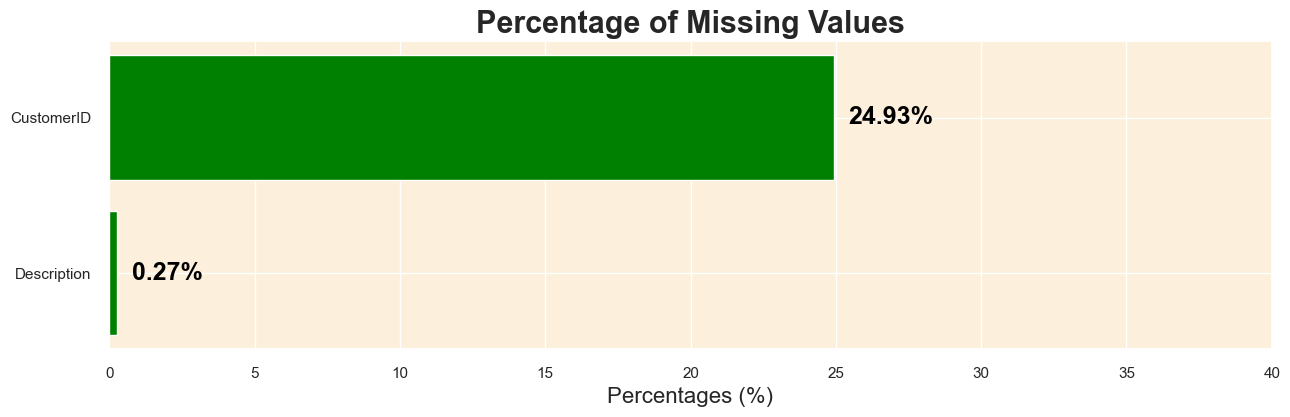

In [114]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='green')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [115]:
df[(df['StockCode'] == '84406B')]

InvoiceNo StockCode                     Description  Quantity  \
2         536365    84406B  CREAM CUPID HEARTS COAT HANGER         8   
51        536373    84406B  CREAM CUPID HEARTS COAT HANGER         8   
68        536375    84406B  CREAM CUPID HEARTS COAT HANGER         8   
280       536396    84406B  CREAM CUPID HEARTS COAT HANGER         8   
418       536406    84406B  CREAM CUPID HEARTS COAT HANGER         8   
...          ...       ...                             ...       ...   
515217    579777    84406B  CREAM CUPID HEARTS COAT HANGER         1   
521149    580317    84406B  CREAM CUPID HEARTS COAT HANGER         8   
522594    580403    84406B  CREAM CUPID HEARTS COAT HANGER         8   
525699    580635    84406B  CREAM CUPID HEARTS COAT HANGER         1   
526594    580673    84406B  CREAM CUPID HEARTS COAT HANGER        16   

             InvoiceDate  UnitPrice  CustomerID         Country  
2         12/1/2010 8:26       2.75     17850.0  United Kingdom  
51        12/1/2010 9:02       2.75     17850.0  United Kingdom  
68        12/1/2010 9:32       2.75     17850.0  United Kingdom  
280      12/1/2010 10:51       2.75     17850.0  United Kingdom  
418      12/1/2010 11:33       2.75     17850.0  United Kingdom  
...                  ...        ...         ...             ...  
515217  11/30/2011 15:13       8.29         NaN  United Kingdom  
521149   12/2/2011 15:29       4.15     13458.0  United Kingdom  
522594   12/4/2011 11:56       4.15     17858.0  United Kingdom  
525699   12/5/2011 12:30       4.15     14649.0  United Kingdom  
526594   12/5/2011 14:30       4.15     13089.0  United Kingdom  

[296 rows x 8 columns]

In [116]:
# Removing rows with missing values by 'CustomerID' and 'Description' columns as a pivot
df = df.dropna(subset=['CustomerID', 'Description'])

In [117]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

* #### 4.2 ***Handling Duplicate Values***

In [118]:
# Find all duplicate rows (included the first one)
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

InvoiceNo StockCode                       Description  Quantity  \
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
537    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
578    536412     21448         12 DAISY PEGS IN WOOD BOX         1   
598    536412     21448         12 DAISY PEGS IN WOOD BOX         1   

         InvoiceDate  UnitPrice  CustomerID         Country  
494  12/1/2010 11:45       1.25     17908.0  United Kingdom  
517  12/1/2010 11:45       1.25     17908.0  United Kingdom  
485  12/1/2010 11:45       4.95     17908.0  United Kingdom  
539  12/1/2010 11:45       4.95     17908.0  United Kingdom  
489  12/1/2010 11:45       2.10     17908.0  United Kingdom  
527  12/1/2010 11:45       2.10     17908.0  United Kingdom  
521  12/1/2010 11:45       2.95     17908.0  United Kingdom  
537  12/1/2010 11:45       2.95     17908.0  United Kingdom  
578  12/1/2010 11:49       1.65     17920.0  United Kingdom  
598  12/1/2010 11:49       1.65     17920.0  United Kingdom

In [119]:
# display total duplicate rows
total_duplicates = df.duplicated().sum()
print(f'Total duplicate : {total_duplicates} rows')

Total duplicate : 5225 rows


In [120]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

In [121]:
# Display total rows in the dataframe
print(f'This dataset has {df.shape[0]} rows')

This dataset has 401604 rows


* #### 4.3 ***Handling Cancelled Transactions***

The cancelled transaction will have the InvoiceNo that start with letter 'C'

In [122]:
df[df['InvoiceNo'].astype(str).str.startswith('C')]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  
141      12/1/2010 9:41      27.50     14527.0  United Kingdom  
154      12/1/2010 9:49       4.65     15311.0  United Kingdom  
235     12/1/2010 10:24       1.65     17548.0  United Kingdom  
236     12/1/2010 10:24       0.29     17548.0  United Kingdom  
237     12/1/2010 10:24       0.29     17548.0  United Kingdom  
...                 ...        ...         ...             ...  
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom  
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom  
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom  
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom  
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom  

[8872 rows x 8 columns]

In [123]:
# create additional column to display the transaction status
df['Transaction_Status'] = np.where((df['InvoiceNo'].astype(str)).str.startswith('C'), 'Cancelled', 'Completed')

In [124]:
# display cancelled transaction 
df[df['Transaction_Status']=='Cancelled']

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  \
141      12/1/2010 9:41      27.50     14527.0  United Kingdom   
154      12/1/2010 9:49       4.65     15311.0  United Kingdom   
235     12/1/2010 10:24       1.65     17548.0  United Kingdom   
236     12/1/2010 10:24       0.29     17548.0  United Kingdom   
237     12/1/2010 10:24       0.29     17548.0  United Kingdom   
...                 ...        ...         ...             ...   
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom   
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom   
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom   
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom   
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom   

       Transaction_Status  
141             Cancelled  
154             Cancelled  
235             Cancelled  
236             Cancelled  
237             Cancelled  
...                   ...  
540449          Cancelled  
541541          Cancelled  
541715          Cancelled  
541716          Cancelled  
541717          Cancelled  

[8872 rows x 9 columns]

In [125]:
# Analyze the cancelled transactions dataframe, whether all quatity value is negative or not
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

all_quantity_neg = (cancelled_transactions['Quantity'] < 0).all()
print(all_quantity_neg)

True


In [126]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


We will retain these cancelled transactions in the dataset for further analysis.

* #### 4.4 ***Correct StockCode Anomalies***

In [127]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


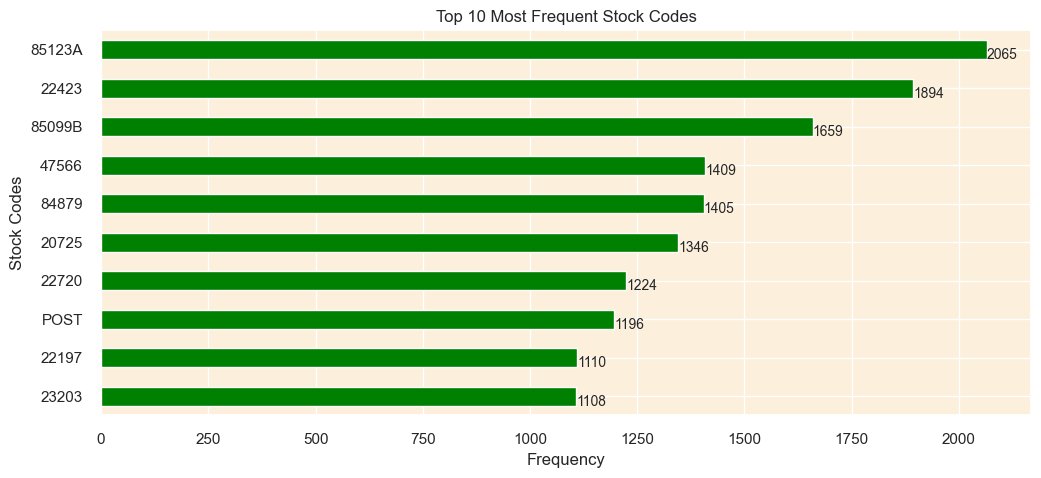

In [128]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts().head(10)

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='green')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value}', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Frequency')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

From above graph, we observe that most of the stock code are 5 numeric character. Let's dive deeper to identifying these anomalies

In [129]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Count of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Count of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


The above output shows it has 3676 unique stock code that has 5 numeric characters, which seems to be standard format for representing stock codes.

In [130]:
# Find and print the stock codes with 0 and 1 numeric characters count
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*50)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
--------------------------------------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [131]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [132]:
df.shape[0]

401604

In [133]:
# filter the anomalies stock codes out from dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [134]:
# after filtered anomalies stock out
df.shape[0]

399689

* #### 4.5 ***Cleaning Description***

Find the number of occurence of each unique description in the dataset. Then sort the number and visualize the top 20 most occurence of each unique description.

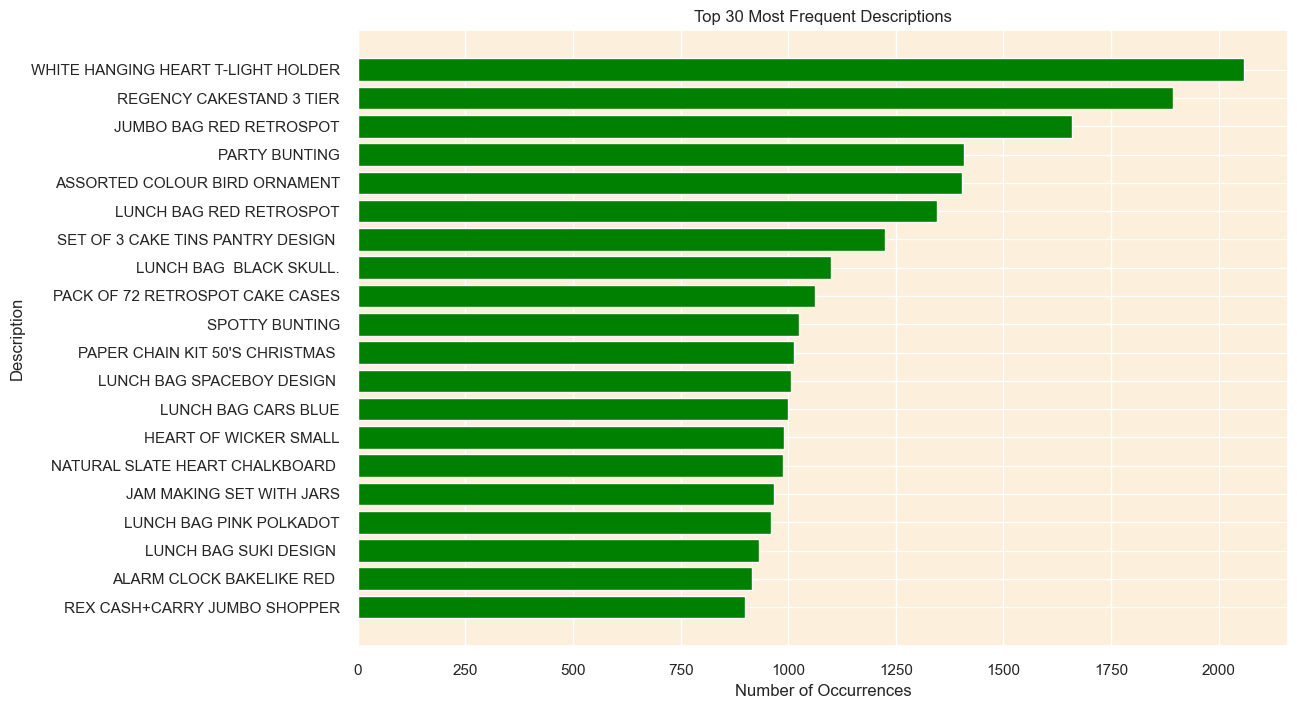

In [135]:
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:20]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='green')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

plt.show()

* From above graph, most of the occurence are generally household items
* We can observe that mostly are uppercase, let check it have any lowercase inside Description

In [136]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]
lowercase_descriptions

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

From this output, there are lowercase contain in some description, but some of them are not product description, such as **Next Day Carriage** and **High Resolution Image**.

In [137]:
# Filter rows with non-product description
non_product_descriptions = ["Next Day Carriage", "High Resolution Image"]

df = df[~df['Description'].isin(non_product_descriptions)]

In [138]:
df.shape[0]

399606

* #### 4.6 ***Treating Zero Unit Prices***

In [139]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

* The minimum unit price is zero. The transaction that contain zero price indicating a free item or a data entry error.
* Including these transactions in the clustering analysis might introduce noise and cause distortion of distance which leading to incorrect cluster assignments. 

In [140]:
# filter the records with a unit price of zero
df = df[df['UnitPrice'] > 0]

In [141]:
df.shape[0]

399573

In [142]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

* #### 4.7 ***Change CustomerID data type***

In [143]:
df['CustomerID'] = df['CustomerID'].astype('int').astype('str')

In [144]:
df.head(3)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

      InvoiceDate  UnitPrice CustomerID         Country Transaction_Status  
0  12/1/2010 8:26       2.55      17850  United Kingdom          Completed  
1  12/1/2010 8:26       3.39      17850  United Kingdom          Completed  
2  12/1/2010 8:26       2.75      17850  United Kingdom          Completed

### Step 5 : Feature Engineering


#### 5.1 *RFM Features*
used to identify customer behavior based on 3 data such as Recency, Frequency, Monetary Value
- **Recency** : the time since customer's last purchase. Shorter period = more interaction
- **Frequency** : number of customer transaction
- **Monetary** : total amount of money a customer has spent over a period

#### Recency(R)

In this step, we focus on understanding how recently a customer has made a purchase. I am going to define the following feature:

**Days Since Last Purchase**: This feature represents the number of days that have passed since the customer's last purchase.
- A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business.
- A higher value may indicate a lapse or decreased engagement.

To do so, I will use InvoiceDate from the dataset and convert into date, then find the most recent purchase date in the datasets and subtract with the last purchase for each customer

In [145]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

In [146]:
# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [147]:
# Now, customer_data dataframe contains the Days_Since_Last_Purchase feature
customer_data.head()

CustomerID  Days_Since_Last_Purchase
0      12346                       325
1      12347                         2
2      12348                        75
3      12349                        18
4      12350                       310

Note: I named the customer-centric dataframe as **customer_data**, which will eventually contain all the customer-based features we plan to create.

#### Frequency (F)

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:
- **Total Transactions**: represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
- **Total Products Purchased**: represents the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

To do so, I will use InvoiceNo from original dataframe to count the total transaction and use the Quantity from original dataframe to count total products purchased. Then I will merge total transaction and total products purchased into customer_data dataframe.

In [148]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

In [149]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

In [150]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  
0                         0  
1                      2458  
2                      2332  
3                       630  
4                       196

#### Monetary (M)

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:
- **Total Spend**: represents the total amount of money spent by each customer. It is calculated as *the sum of the product of UnitPrice and Quantity for all transactions made by a customer*.
    -  helps in identifying the total revenue generated by each customer
- **Average Transaction Value**: indicates the average value of a transaction carried out by a customer. This feature is calculated as the *Total Spend divided by the Total Transactions for each customer*.
    - understanding the spending behavior of customers

In [151]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

In [152]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

In [153]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  
0                         0         0.00                   0.000000  
1                      2458      4310.00                 615.714286  
2                      2332      1437.24                 359.310000  
3                       630      1457.55                1457.550000  
4                       196       294.40                 294.400000

#### 5.2 *Product Diversity*

- understand the diversity in the product purchase behavior of customers.
- understanding product diversity can help in crafting personalized marketing strategies and product recommendations

Define the following feature:
- **Unique Products Purchased**: This feature represents the number of distinct products bought by a customer.
    - A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products
    - A lower value might indicate a focused or specific preference.

In [154]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

In [155]:
# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  
0                          1  
1                        103  
2                         21  
3                         72  
4                         16

#### 5.3 *Behavioral Features*

- understand and capture the shopping patterns and behaviors of customers.
- These features will give us insights into the customer's preferences regarding when they like to shop

- Here are the features :
    - **Average Days Between Purchases**: This feature represents the average number of days a customer waits before making another purchase.
        - this feature can help in predicting when the customer is likely to make their next purchase
    - **Favorite Shopping Day**: represent the day of the week when the customer shops the most
        - this feature can help in identifying the preferred shopping days of different customer segments
    - **Favorite Shopping Hour**: refers to the hour of the day when the customer shops the most.
        - identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions

In [156]:
# Average Days Between Purchases

# extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))

average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

In [157]:
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

In [158]:
# Favorite Shopping Day

favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

In [159]:
# Favorite Shopping Hour
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

In [160]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [161]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  
0    10  
1    14  
2    19  
3     9  
4    16

#### 5.4 *Geographic Features*

- introduce a geographic feature that reflects the geographical location of customers

In [162]:
# check which country has the most transaction
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

- We observe that 89% of transactions are originating from the United Kingdom
- So I will consider creating a binary feature indicating whether the transaction is from the UK or not. This approach will improve clustering process performance

Implementation
- First, I will group the data by *CustomerID* and *Country* and calculate the number of transactions per country for each customer.
- Next, identify the main country for each customer (the country from which they have the maximum transactions).
- Then, create a binary column indicating whether the customer is from the UK or not.
- Finally, merge this information with the *customer_data* dataframe to include the new feature in our analysis.

In [163]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

In [164]:
# Get the country with the maximum number of transactions for each customer
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

In [165]:
# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

In [166]:
# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

In [167]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  
0    10      1  
1    14      0  
2    19      0  
3     9      0  
4    16      0

In [168]:
# Count how many are UK. and non-UK
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

#### 5.5 *Cancellation Insights*

In this step, I am going to dive deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:
- **Cancellation Frequency**: the total number of transactions a customer has canceled.
- **Cancellation Rate**: the proportion of transactions that a customer has canceled out of all their transactions
    - gives a normalized view of cancellation behavior

In [169]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

In [170]:
# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)
# cancellation_frequency.head(3)

In [171]:
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

In [172]:
customer_data.head(3)

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   

   Hour  Is_UK  Cancellation_Frequency  
0    10      1                     1.0  
1    14      0                     NaN  
2    19      0                     NaN

In [173]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

In [174]:
# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

In [175]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  
0    10      1                     1.0                0.5  
1    14      0                     0.0                0.0  
2    19      0                     0.0                0.0  
3     9      0                     0.0                0.0  
4    16      0                     0.0                0.0

#### 5.6 *Seasonality & Trends*

In this step, I will delve into the seasonality and trends in customers' purchasing behaviors
    - which can offer insights for tailoring marketing strategies and enhancing customer satisfaction.

Here are the features : 
- **Monthly_Spending_Mean**: This is the average amount a customer spends monthly.
    - indicate general spending habit of each customer 
- **Monthly_Spending_Std**: indicates the variability in a customer's monthly spending
    - example : a customer might generally spend a moderate amount each month, but occasionally, they make large purchases.
- **Spending_Trend**: reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data.
    - A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction(vice versa).

In [176]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [177]:
# Calculate monthly spending for each customer

monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()
monthly_spending.head(2)

CustomerID  Year  Month  Total_Spend
0      12346  2011      1         0.00
1      12347  2010     12       711.79

In [178]:
# Calculate Seasonal Buying Patterns

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

seasonal_buying_patterns.head(3)

CustomerID  Monthly_Spending_Mean  Monthly_Spending_Std
0      12346               0.000000              0.000000
1      12347             615.714286            341.070789
2      12348             359.310000            203.875689

In [179]:
# Calculate Trends in Spending
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [180]:
# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

In [181]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

In [182]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                     1.0                0.5   
1    14      0                     0.0                0.0   
2    19      0                     0.0                0.0   
3     9      0                     0.0                0.0   
4    16      0                     0.0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0               0.000000              0.000000        0.000000  
1             615.714286            341.070789        4.486071  
2             359.310000            203.875689     -100.884000  
3            1457.550000              0.000000        0.000000  
4             294.400000              0.000000        0.000000

In [183]:
# changing data type of customerID
customer_data['CustomerID'] = customer_data['CustomerID'].astype(int).astype(str)

# automatically convert the columns of a DataFrame to the most appropriate data types
customer_data = customer_data.convert_dtypes()

customer_data['CustomerID'].dtypes

string[python]

In [184]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0          0.0                        0.0   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0                    0.0                   0.0             0.0  
1             615.714286            341.070789        4.486071  
2                 359.31            203.875689        -100.884  
3                1457.55                   0.0             0.0  
4                  294.4                   0.0             0.0

In [185]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

## Customer Data Variables

Below is a description of each variable collected in the customer dataset:

| Variable                    | Description |
|-----------------------------|-------------|
| `CustomerID`                | Identifier uniquely assigned to each customer, used to distinguish individual customers. |
| `Days_Since_Last_Purchase`  | The number of days that have passed since the customer's last purchase. |
| `Total_Transactions`        | The total number of transactions made by the customer. |
| `Total_Products_Purchased`  | The total quantity of products purchased by the customer across all transactions. |
| `Total_Spend`               | The total amount of money the customer has spent across all transactions. |
| `Average_Transaction_Value` | The average value of the customer's transactions, calculated as total spend divided by the number of transactions. |
| `Unique_Products_Purchased` | The number of different products the customer has purchased. |
| `Average_Days_Between_Purchases` | The average number of days between consecutive purchases made by the customer. |
| `Day_Of_Week`               | The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday). |
| `Hour`                      | The hour of the day when the customer prefers to shop, represented in a 24-hour format. |
| `Is_UK`                     | A binary variable indicating whether the customer is based in the UK (1) or not (0). |
| `Cancellation_Frequency`    | The total number of transactions that the customer has cancelled. |
| `Cancellation_Rate`         | The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions. |
| `Monthly_Spending_Mean`     | The average monthly spending of the customer. |
| `Monthly_Spending_Std`      | The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern. |
| `Spending_Trend`            | A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend. |


### Step 6 : Outlier Detection and Treatment

- outliers can significantly affect the performance of k-means clustering by shifting the Centroid, which causing Incorrect Clustering.
- therefore, we need to handle with outlier with **Isolation Forest algorithm**.

In [186]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

In [187]:
# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0          0.0                        0.0   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
0                    0.0                   0.0             0.0   
1             615.714286            341.070789        4.486071   
2                 359.31            203.875689        -100.884   
3                1457.55                   0.0             0.0   
4                  294.4                   0.0             0.0   

   Outlier_Scores  Is_Outlier  
0               1           0  
1               1           0  
2               1           0  
3               1           0  
4               1           0

Now let's visualize the distribution of these scores and the number of inliers and outliers detected by the model:

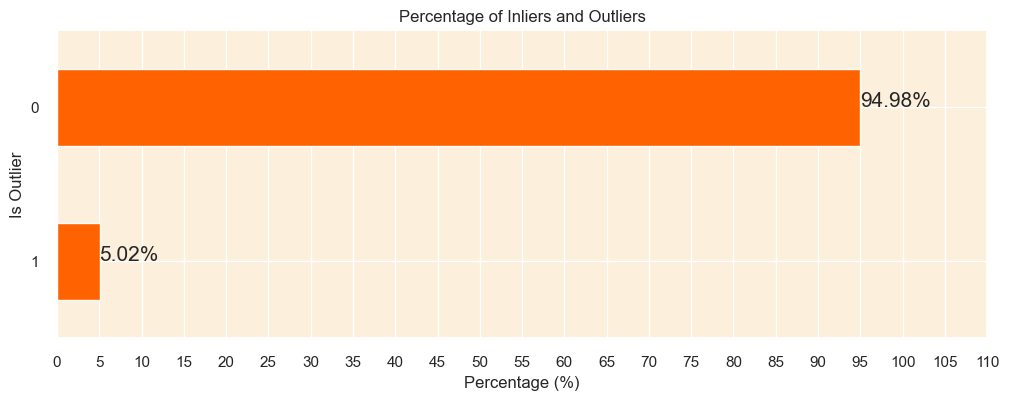

In [188]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

we observed that about 5% of the customers have been identified as outliers in our dataset.

Handle with outlier strategy
- Separate the identified outliers for further analysis and save them as a separate file (optional).
- Remove the outliers from the main dataset to prevent them from influencing the clustering process.
- Drop the **Outlier_Scores** and **Is_Outlier** columns as they were auxiliary columns used for the outlier detection process.

In [189]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [190]:
customer_data_cleaned.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0          0.0                        0.0   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0                    0.0                   0.0             0.0  
1             615.714286            341.070789        4.486071  
2                 359.31            203.875689        -100.884  
3                1457.55                   0.0             0.0  
4                  294.4                   0.0             0.0

In [191]:
customer_data_cleaned.shape[0]

4067

### Step 7 : Correlation Analysis

- Checking the correlation between features before performing k-means clustering to Improving clustering quality.
Reducing computation.
- Features that are highly correlated often provide overlapping or redundant information.

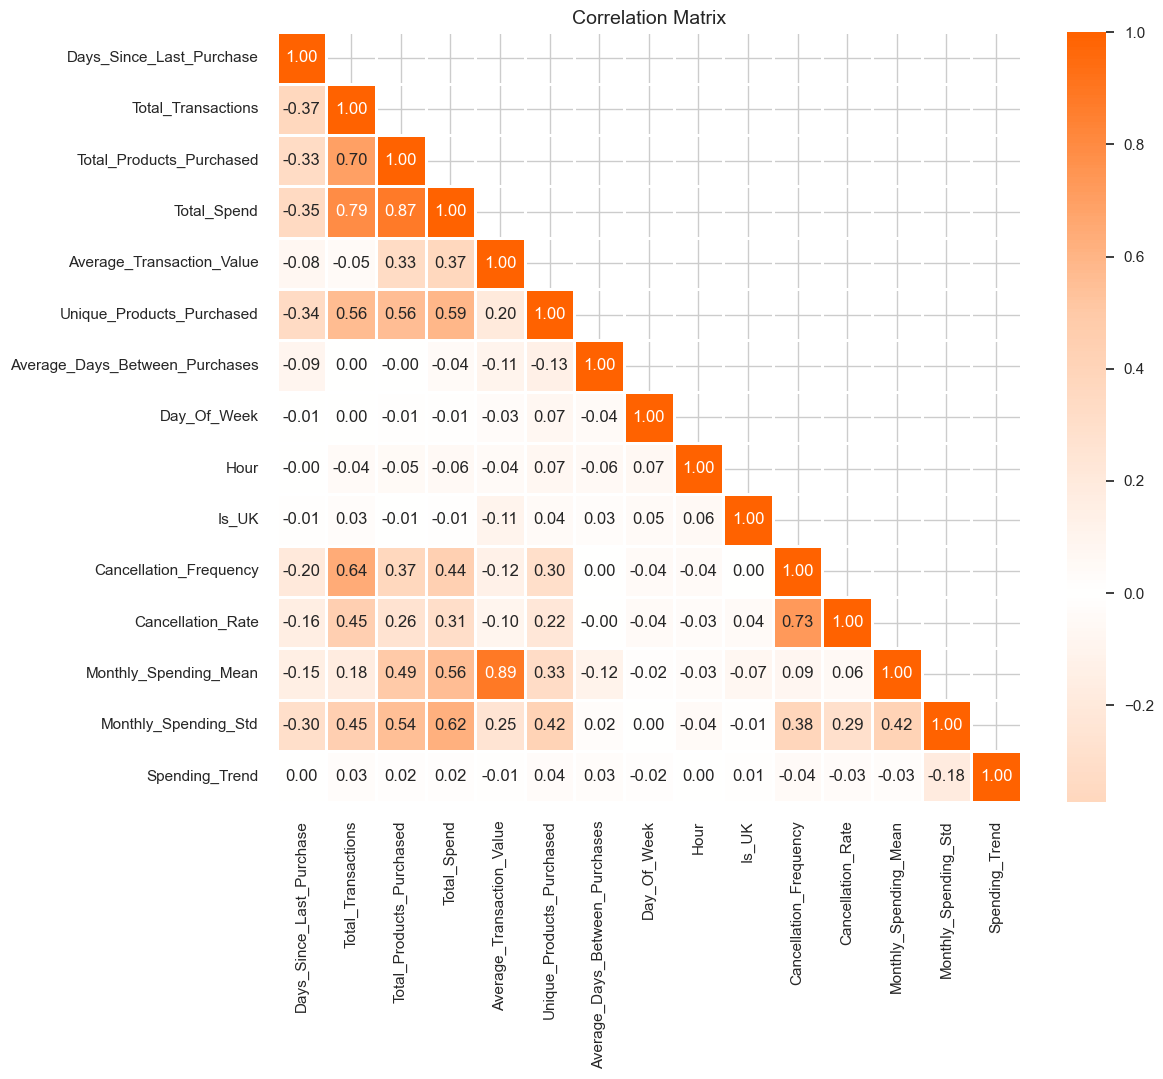

In [192]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

We observe from above heatmap that there are some pairs of variables that have high correlations
- **Monthly_Spending_Mean** and **Average_Transaction_Value**
- **Total_Spend** and **Total_Products_Purchased**
- **Total_Transactions** and **Total_Spend**
- **Cancellation_Rate** and **Cancellation_Frequency**
- **Total_Transactions** and **Total_Products_Purchased**
</br>
These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

### Step 8 : Feature Scaling

Before move forward with the clustering and dimensionality reduction, I will scale the features first. The larger value disproportionately influence the clustering outcome and not accurately reflecting the underlying patterns in the data.


Here are the exceptions and the reasons why they are excluded: **CustomerID**, **Is_UK** and **Day_Of_Week**

In [193]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

In [194]:
customer_data_scaled.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                  2.345802           -0.477589   
1      12347                 -0.905575            0.707930   
2      12348                 -0.170744           -0.003381   
3      12349                 -0.744516           -0.714692   
4      12350                  2.194809           -0.714692   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                 -0.754491    -0.813464                  -1.317106   
1                  2.005048     2.366920                   1.528132   
2                  1.863591     0.247087                   0.343279   
3                 -0.047205     0.262074                   5.418285   
4                 -0.534446    -0.596223                   0.043327   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                  -0.908471                       -0.310564            1   
1                   0.815119                       -0.128438            1   
2                  -0.570512                        0.672476            3   
3                   0.291283                       -0.310564            0   
4                  -0.655002                       -0.310564            2   

       Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0 -1.086929      1                0.420541           0.417623   
1  0.647126      0               -0.545753          -0.432111   
2  2.814696      0               -0.545753          -0.432111   
3 -1.520443      0               -0.545753          -0.432111   
4  1.514154      0               -0.545753          -0.432111   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0              -1.329018             -0.713318        0.090868  
1               0.989511              1.259961        0.116774  
2               0.023997              0.466213       -0.491708  
3               4.159521             -0.713318        0.090868  
4              -0.220428             -0.713318        0.090868

### Step 9 : Dimensionality Reduction

#### Step 9.1 : Plot the cumulative variance

Implementation :
- I will apply PCA on all the available components and plot the cumulative variance explained by them.
- this process will allow me to visualize how much variance each additional principal component can explain
    - helping me to obtain the optimal number of components to retain for the analysis

In [195]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

In [196]:
# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

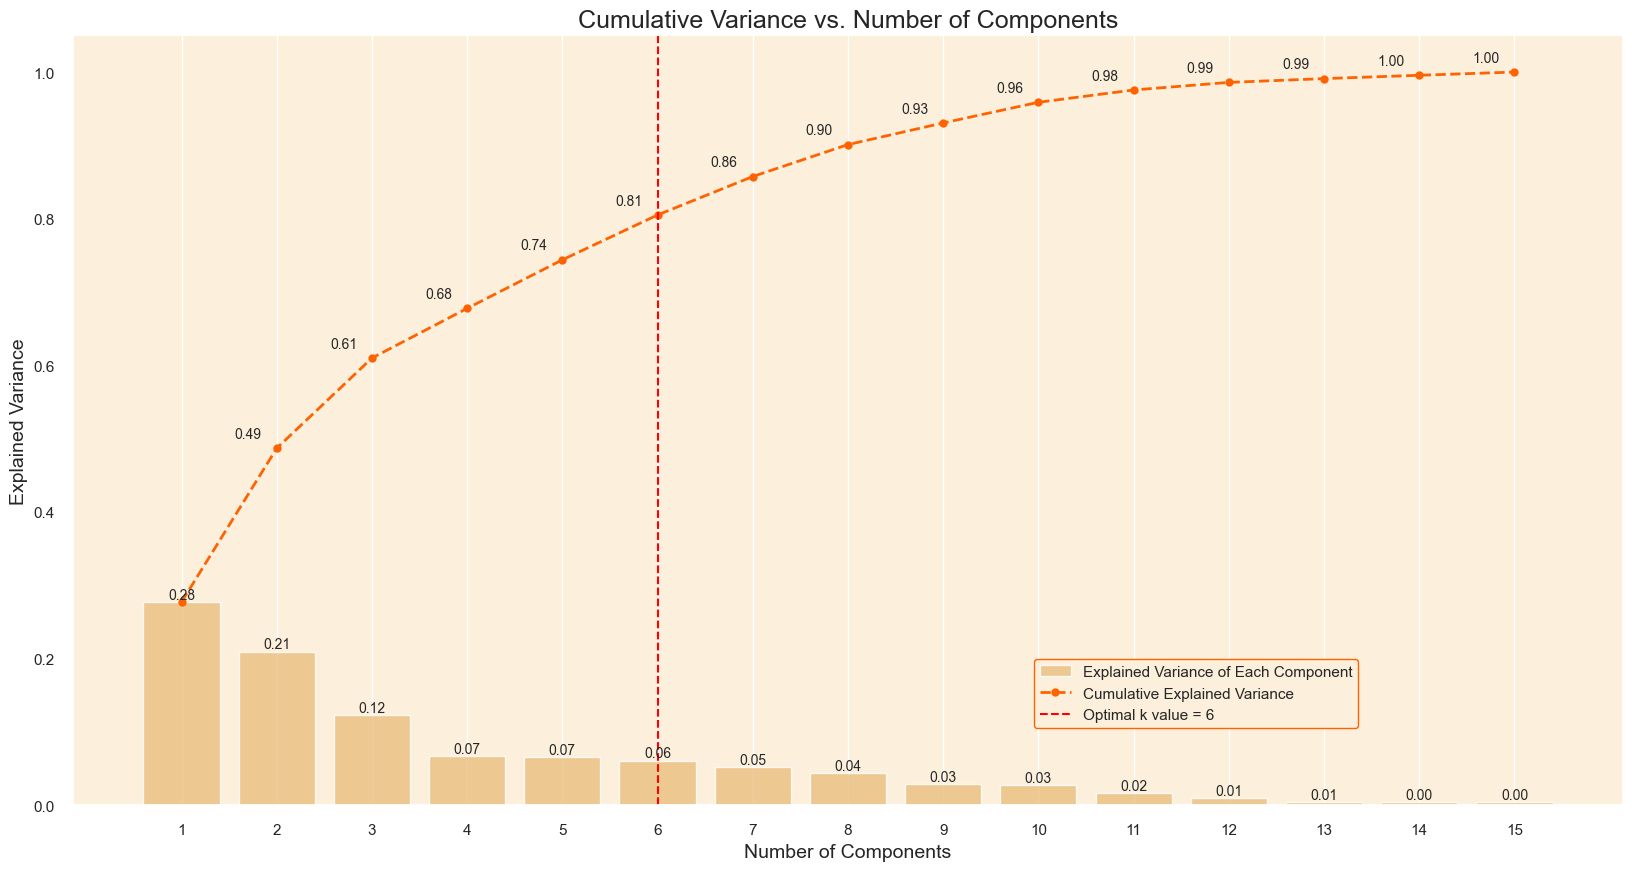

In [197]:
# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

#####################################################################################################

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

plt.grid(axis='both')
plt.show()

##### **Conclusion**
- Here, we can observe that:
    - The first component explains approximately 28% of the variance.
    - The first two components together explain about 49% of the variance.
    - The first three components explain approximately 61% of the variance, and so on.
- From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).
- Therefore, I will retain the **first 6 components**

In [198]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

#### Step 9.2 : Creating a PCA

In [199]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [200]:
customer_data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
CustomerID                                                            
12346      -2.186469 -1.705370 -1.576745  1.008187 -0.411803 -1.658012
12347       3.290264 -1.387375  1.923310 -0.930990 -0.010591  0.873150
12348       0.584684  0.585019  0.664727 -0.655411 -0.470280  2.306657
12349       1.791116 -2.695652  5.850040  0.853418  0.677111 -1.520098
12350      -1.997139 -0.542639  0.578781  0.183682 -1.484838  0.062672

highlight the top 3 highest absolute values in each component, it helpful because it provides insights into which features are most influential in shaping the principal components 

In [201]:
# Define a function to highlight the top 3 highest absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  green' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

### Step 10 : K-Means Clustering

#### Step 10.1 : Determining the Optimal Number of Clusters

I will explore two renowned methods:**Elbow Method** and **Silhouette Method**, both are used to determine the optimal number of clusters (k) for clustering algorithms

- ### Elbow Method

 I will employ the YellowBrick library to facilitate the implementation of the Elbow method. YellowBrick, an extension of the Scikit-Learn API, is renowned for its ability to rapidly generate insightful visualizations in the field of machine learning.

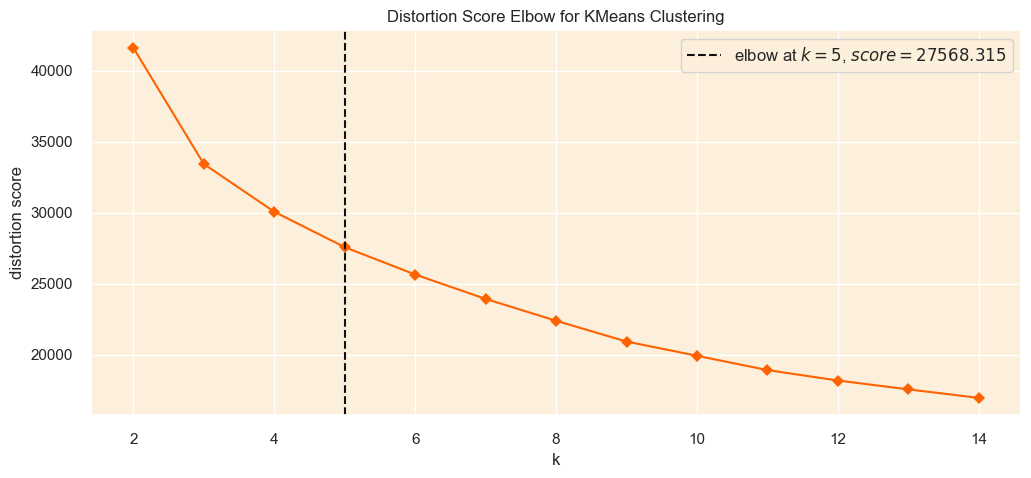

In [202]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

We observe that the suggested optimal k value is 5. However, we don't have a very distinct elbow point in this case, but from our visualization indicating that **the optimum value of k could be between 3 and 7**. Let's try **silhouette method**.

- ### Silhouette Method

- It computes the **silhouette coefficient** for each data point, which measures how similar a point is to its own cluster compared to other clusters.
- Compute Silhouette Coefficient
    - Calculate a(i): Compute the average distance between point i and all other points within its cluster.
    - Calculate b(i): Compute the average distance between point i and all points in the nearest cluster to its own.
    - Compute the silhouette coefficient, s(i), for point i using the following formula:
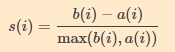

silhouette score is **the average silhouette coefficient** calculated for all data points in a dataset

**Implementation**
- I will initially choose a range of 2-6 for the number of clusters (k) based on the Elbow method from the previous section. Next, I will plot Silhouette scores for each k value to determine the one with the highest score.
- Subsequently, to fine-tune the selection of the most appropriate k, I will generate Silhouette plots that visually display the silhouette coefficients for each data point within various clusters.


In [219]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    ''' First plot: Silhouette scores for different k values '''
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))

    ''' Second plot (subplot): Silhouette plots for each k value '''
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.3f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)
    
    plt.tight_layout()
    plt.show()


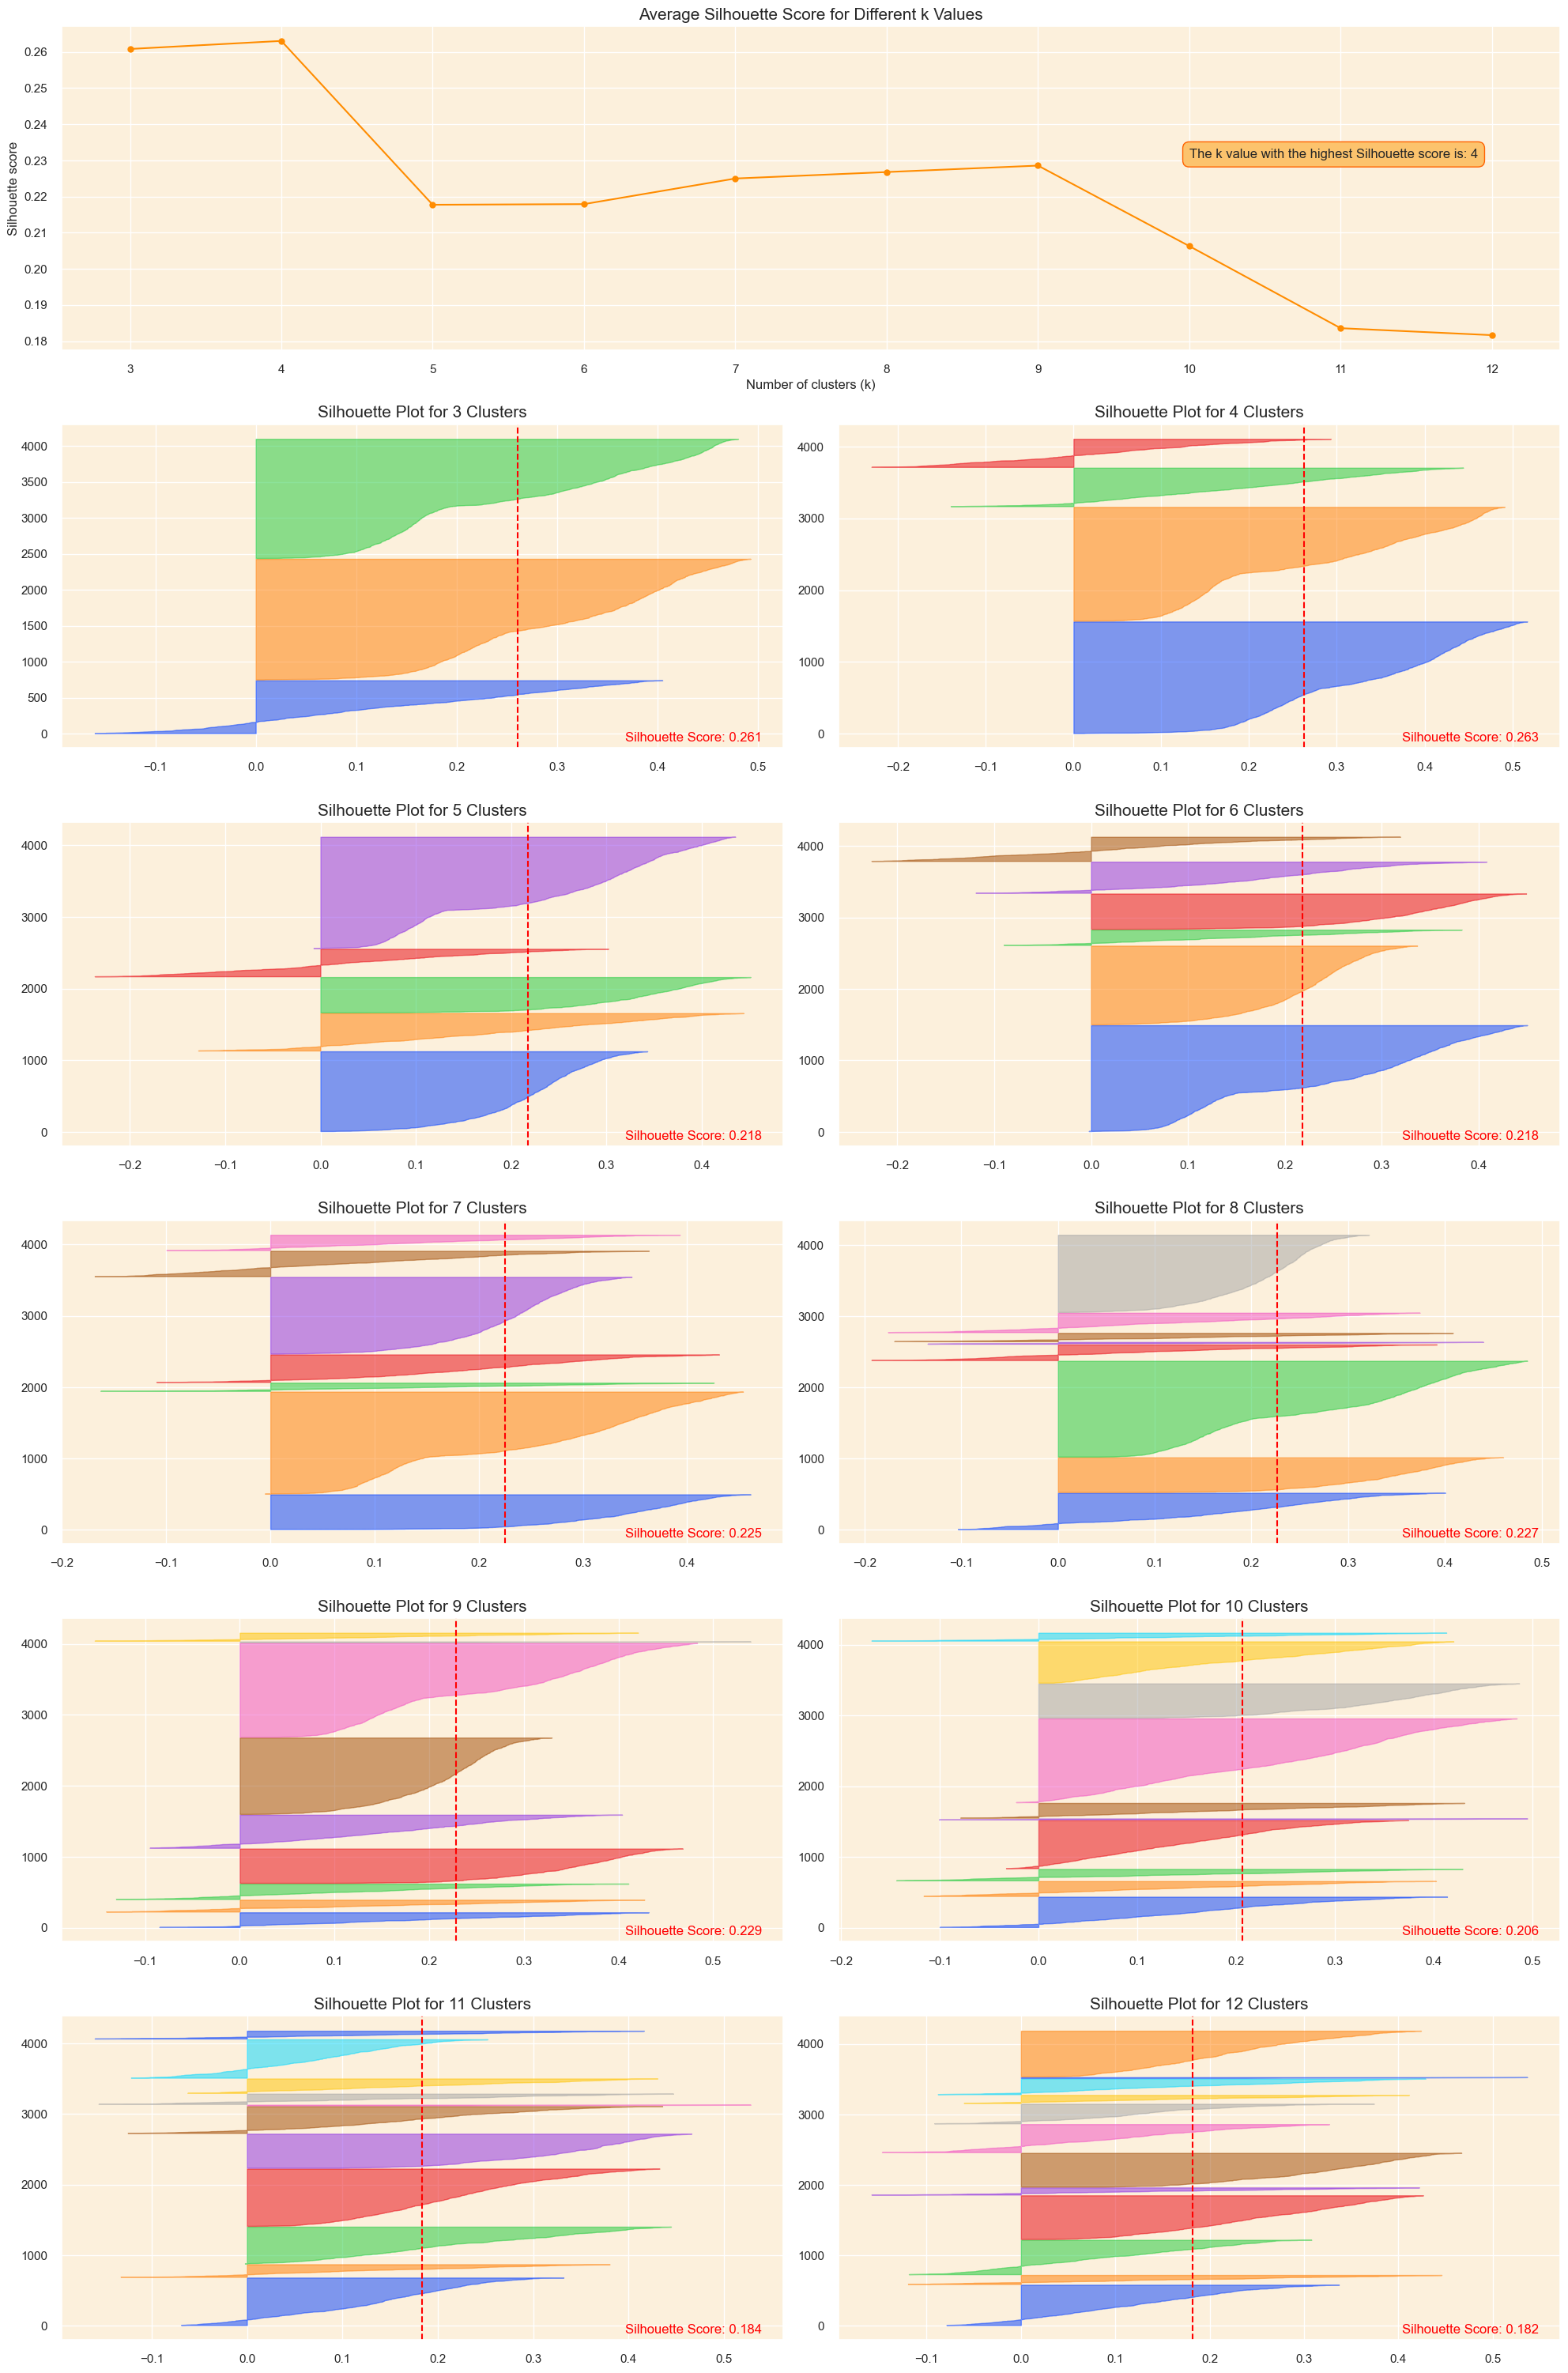

In [220]:
# perform silhouette analysis
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

After analyzed the silhouette plot, we observed that choosing (k = 3) is the better option because it gives us clusters that are more evenly matched and well-defined

#### Step 10.2 : Clustering Model - K-means

In this step, I will use K-means clustering algorithm to segment customers into different clusters based on their purchasing behaviors and other characteristics by using optimal no. of cluster(k) that found in previous step.

In [205]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=0)

In [206]:
# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)
cluster_frequencies

Counter({0: 1677, 2: 1656, 1: 734})

In [207]:
# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [208]:
customer_data_cleaned.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0      12346                       325                   2   
1      12347                         2                   7   
2      12348                        75                   4   
3      12349                        18                   1   
4      12350                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0          0.0                        0.0   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  cluster  
0                    0.0                   0.0             0.0        1  
1             615.714286            341.070789        4.486071        2  
2                 359.31            203.875689        -100.884        0  
3                1457.55                   0.0             0.0        1  
4                  294.4                   0.0             0.0        1

### Step 11 : Clustering Evaluation

- This step is essential to validate the effectiveness of the clustering and to ensure that the clusters are coherent and well-separated
- The evaluation metrics and a visualization technique
    - 1️⃣ **3D Visualization of Top PCs**
    - 2️⃣ **Cluster Distribution Visualization**
    - 3️⃣ **Evaluation Metrics** : Silhouette Score, 
Calinski Harabasz Scor, 
Davies Bouldin Score

**Note**: I will using the PCA version of the dataset for evaluation because this is the space where the clusters were actually formed, capturing the most significant patterns in the data to ensures a more accurate representation of the cluster quality.

- #### 3D Visualization of Top Principal Components

In this part, I am going to choose the top 3 PCs and use them to create a 3D visualization.

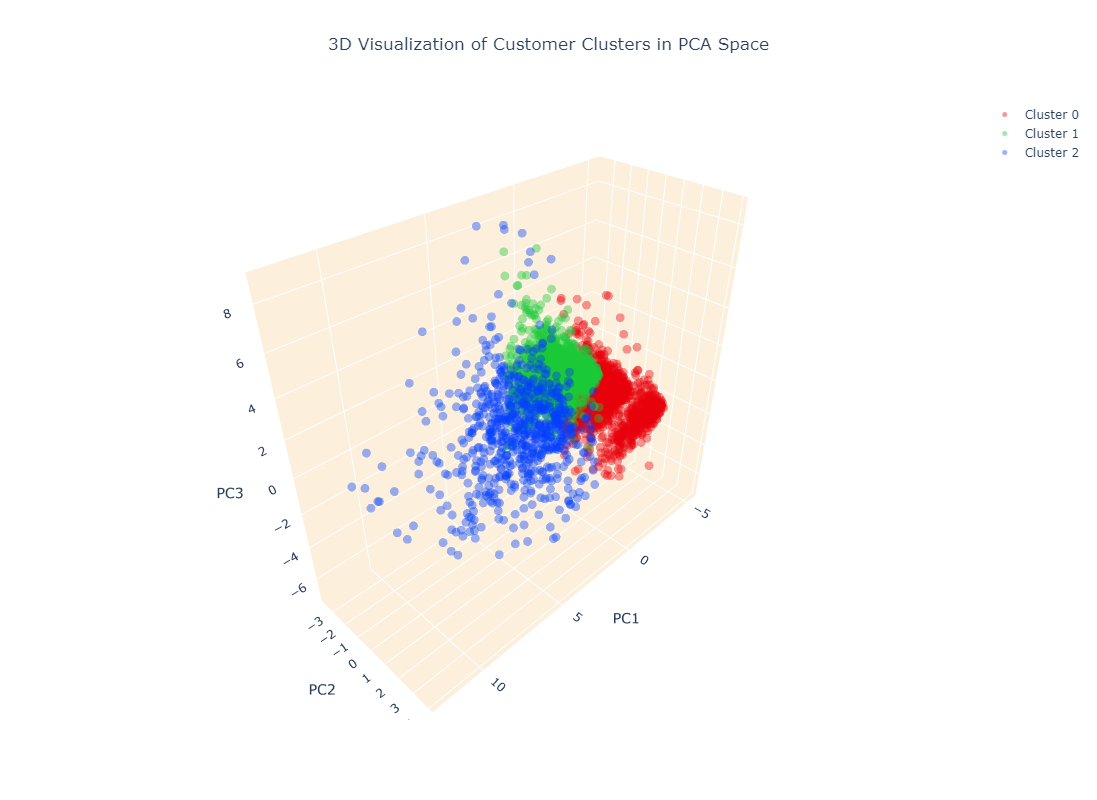

In [209]:
# Setting up the color for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

- #### Cluster Distribution Visualization

I am going to utilize a bar plot to visualize the percentage of customers in each cluster, which helps in understanding if the clusters are balanced and significant:


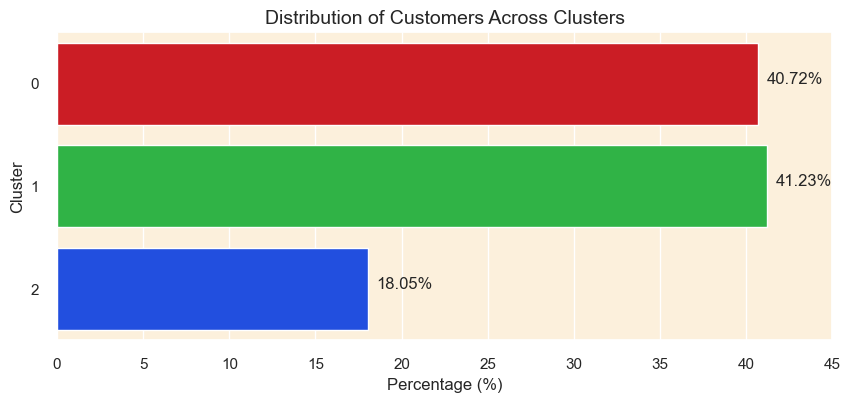

In [210]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

From this bar plot, clusters 0 and 1 holding around 41% of customers each and cluster 2 accommodating approximately 18% of the customers.- This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers.
- Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data.


- #### Evaluation Model Performance

I will use 3 score to evaluate the quality of clustering
- **Silhouette Score**: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.
- **Calinski Harabasz Score**: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.
- **Davies Bouldin Score**: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.


In [211]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = round(silhouette_score(X, clusters), 3)
calinski_score = round(calinski_harabasz_score(X, clusters), 3)
davies_score = round(davies_bouldin_score(X, clusters), 3)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

In [212]:
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+----------+
|         Metric          |  Value   |
+-------------------------+----------+
| Number of Observations  |   4067   |
|    Silhouette Score     |  0.236   |
| Calinski Harabasz Score | 1257.179 |
|  Davies Bouldin Score   |  1.368   |
+-------------------------+----------+


Clustering Quality Conclusion
- The **Silhouette Score** of 0.236, although not close to 1, it still fair amount of separation between the clusters and indicates reasonable structure. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them.
- The **Calinski Harabasz Score** of 1257.179, which is considerably high, indicating that the clusters are well-defined.
- The **Davies Bouldin Score** of 1.368 is considered low, which is reasonable because the fair score of Silhouette Score and high score of Calinski Harabasz Score.

## Step 11 : Cluster Analysis and Profiling

In this section, I am going to analyze the characteristics of each cluster to understand the distinct behaviors and preferences of different customer segments and also describe each cluster to identify the key traits that define the customers in each cluster.

- ### Radar Chart Approach

First, I will going to create radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.

- To construct the radar charts, it's essential to first compute the centroid for each cluster. 
- This centroid represents the mean value for all features within a specific cluster.
- Finally, I will display these centroids on the radar charts, to get a clear visualization of the central tendencies of each feature across the various clusters

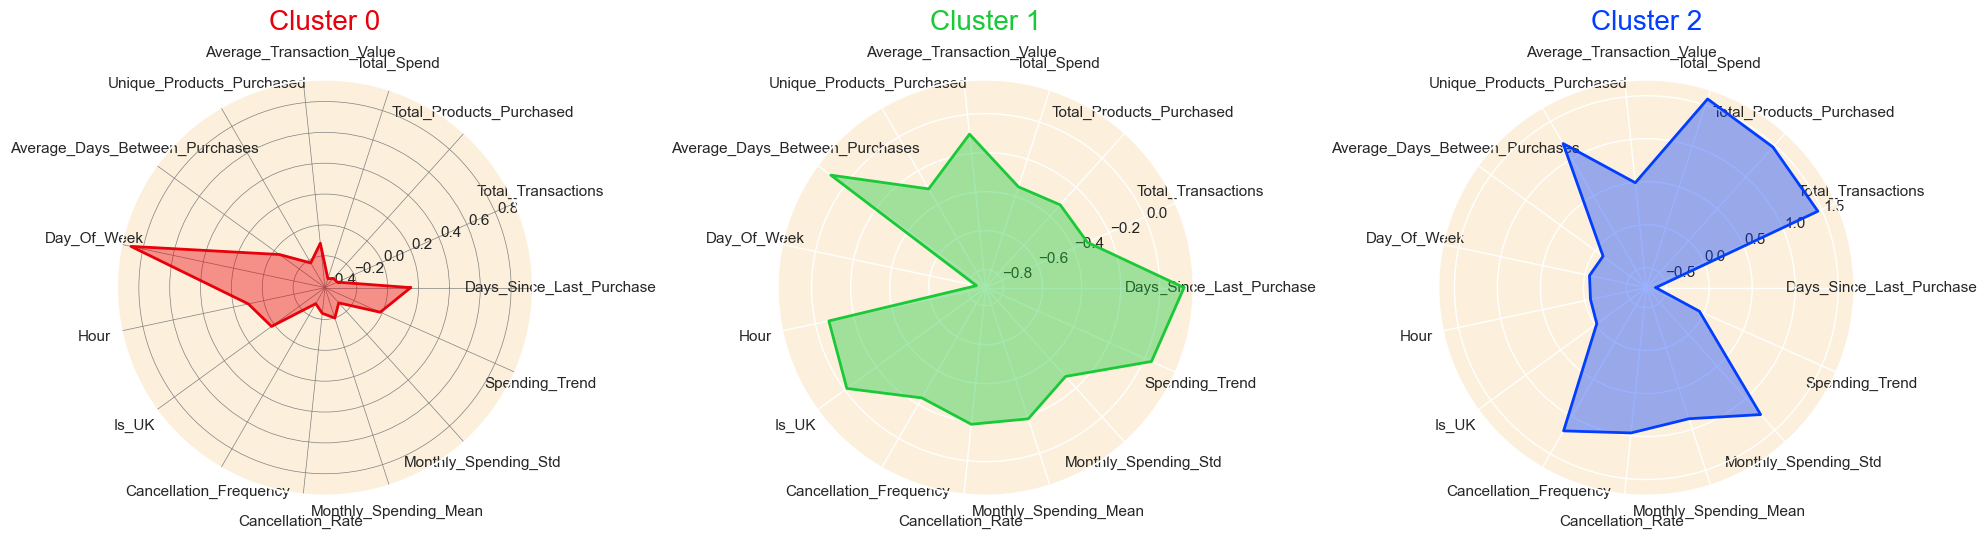

In [213]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

Customer Characterized Derived from Radar Chart Analysis
- **Cluster 0**
    - Customers in this cluster tend to spend less (low monthly_Spending_Mean).
    - They loves to buy in weekend (due to very high Day_of_Week value).
    - They spending behavior are stable (low Monthly_Spending_Std). 
    - *They have a slight tendency to shop during the weekends*.
    - **Weekend Shopping Customers**


- **Cluster 1**
    - Customers in this cluster show a moderate level of spending
    - their transactions are not very frequent, as indicated by the high **Days_Since_Last_Purchase** and **Average_Days_Between_Purchases**.
    - They have a very high spending trend, indicating that their spending has been increasing over time.
    - *They are not frequent big spenders with a high spending tren
    - **Infrequent Big Spenders with a High Spending Trend Customers**d*
- **Cluster 2**
    - Customers in this cluster are high spenders with a very high total spend.
    - have a high cancellation frequency.
    - *They are frequent high-spenders with a high rate of cancellation
    - **Frequent High-Spenders with a High Rate of Cancellations Customers**s*

## Step 12 : Recommendation System

In this step, I am set to develop a recommendation system to enhance the online shopping experience by **suggesting the top three products** popular within their cluster that they have not yet purchased.
- This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales.

In [214]:
# outlier customer data
outliers_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
9       12356                        22                   3   
10      12357                        33                   1   
12      12359                         7                   6   
26      12377                       315                   2   
27      12378                       129                   1   

    Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
9                       1573      2487.43                 829.143333   
10                      2708      6207.67                    6207.67   
12                      1599      6182.98                1030.496667   
26                       942      1548.12                     774.06   
27                      2529      4008.62                    4008.62   

    Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
9                          52                        5.315789            1   
10                        131                             0.0            6   
12                        214                           1.296            3   
26                         71                            0.52            0   
27                        219                             0.0            1   

    Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
9      9      0                       0                0.0   
10    16      0                       0                0.0   
12    12      0                       2           0.333333   
26     9      0                       0                0.0   
27    10      0                       0                0.0   

    Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
9              829.143333            991.462585        -944.635   
10                6207.67                   0.0             0.0   
12            1030.496667           1137.566659       25.072571   
26                 774.06            321.677017         -454.92   
27                4008.62                   0.0             0.0   

    Outlier_Scores  Is_Outlier  
9               -1           1  
10              -1           1  
12              -1           1  
26              -1           1  
27              -1           1

I will filtered 5% of the customers identified as outliers from main dataframe and reserved them in a separate dataset called outliers_data. and we no longer to use this outlier data anymore 


In [215]:
# Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('str').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

build the recommendation system

In [216]:
# Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('str')

# Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [217]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

Rec1_StockCode                     Rec1_Description Rec2_StockCode  \
CustomerID                                                                      
15746               84879        ASSORTED COLOUR BIRD ORNAMENT          15036   
15728               84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
17459               18007  ESSENTIAL BALM 3.5g TIN IN ENVELOPE          84879   
17415               18007  ESSENTIAL BALM 3.5g TIN IN ENVELOPE          84879   
15339               18007  ESSENTIAL BALM 3.5g TIN IN ENVELOPE          84879   
14335               84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
15367               22616           PACK OF 12 LONDON TISSUES           84879   
17604               84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
17828               22616           PACK OF 12 LONDON TISSUES           84077   
13229               84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   

                             Rec2_Description Rec3_StockCode  \
CustomerID                                                     
15746               ASSORTED COLOURS SILK FAN         85123A   
15728           ASSORTED COLOUR BIRD ORNAMENT          15036   
17459           ASSORTED COLOUR BIRD ORNAMENT          17003   
17415           ASSORTED COLOUR BIRD ORNAMENT          17003   
15339           ASSORTED COLOUR BIRD ORNAMENT          17003   
14335           ASSORTED COLOUR BIRD ORNAMENT          15036   
15367           ASSORTED COLOUR BIRD ORNAMENT          16014   
17604           ASSORTED COLOUR BIRD ORNAMENT          15036   
17828       WORLD WAR 2 GLIDERS ASSTD DESIGNS         85099B   
13229           ASSORTED COLOUR BIRD ORNAMENT          15036   

                              Rec3_Description  
CustomerID                                      
15746       WHITE HANGING HEART T-LIGHT HOLDER  
15728                ASSORTED COLOURS SILK FAN  
17459                      BROCADE RING PURSE   
17415                      BROCADE RING PURSE   
15339                      BROCADE RING PURSE   
14335                ASSORTED COLOURS SILK FAN  
15367              SMALL CHINESE STYLE SCISSOR  
17604                ASSORTED COLOURS SILK FAN  
17828                  JUMBO BAG RED RETROSPOT  
13229                ASSORTED COLOURS SILK FAN